# Sentiment Analysis Using Machine Learning

## Dataset Link

[Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140)

### Table of Content
- [Data Analysis](#section-1)
- [Balance The Data](#section-2)
- [Data Preprocessing](#section-3)
- [Train The Model](#section-4)
- [Result](#section-5)

In [1]:
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
import warnings
import pickle
warnings.filterwarnings('ignore')

## Data Analysis<a id="section-1"></a>

In [2]:
df = pd.read_csv('./data/training.1600000.processed.noemoticon.csv',
                 delimiter=',', encoding='ISO-8859-1')
df.columns = ['Sentiment','id','date','query','user','text']
df.head()

,Sentiment,id,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [3]:
df = df[['Sentiment','text']]
df.head()

,Sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [4]:
df['Sentiment'] = df['Sentiment'].replace({4:1})

In [5]:
df['Sentiment'].value_counts()

0    799996
1    248576
Name: Sentiment, dtype: int64

In [6]:
df.isna().sum().sum() # find nan

0

#### Visualizing the count

* 0 represent Negative sentiment
* 1 represents Positive sentiment

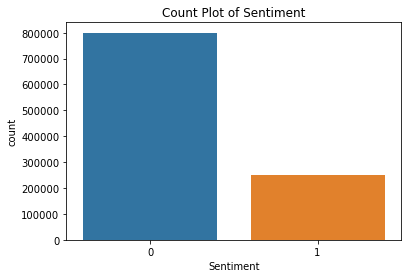

In [7]:
sns.countplot(df["Sentiment"])
plt.title("Count Plot of Sentiment")
plt.show()

In [8]:

## majority class 0
df_majority = df[df['Sentiment']==0]
## minority class 1
df_minority = df[df['Sentiment']==1]

**Inference: The data is unbalanced therfore we will downsample the data to have same count for each sentiment**

## Downsampling the dataset<a id="section-2"></a>

In [9]:
# downsample the majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,   
                                 n_samples=len(df_minority),    
                                 random_state=1234) 

In [10]:
df = df_majority_downsampled.append(df_minority)
df.head()

,Sentiment,text
74567,0,Wow slept for almost 12hours. Sleepy me!! Uni ...
668722,0,gets bored with an idea too easily ... like tw...
286706,0,To my girls - sorry i've been a homebody latel...
632911,0,BK once again for the weekend...If it wasnt fo...
356735,0,@DonnieWahlberg Now why didn't you do that las...


#### Visualizing after downsampling

248576 data for each class

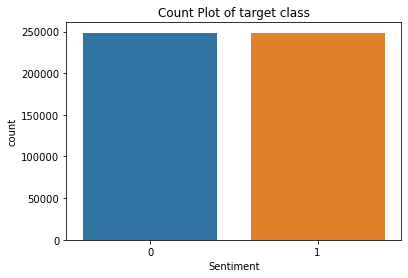

In [11]:
sns.countplot(df["Sentiment"])
plt.title("Count Plot of target class")
plt.show()

## Data Preprocessing<a id="section-3"></a>

1. removing stop words
2. removing punctuations
3. Lemmatizing
4. removing tags
5. removing special characters 
6. lowercase conversion

In [12]:
## remove stopwords and punctuation marks
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation)
stemmer = LancasterStemmer()

corpus = df['text'].tolist()

In [13]:
%%time
final_corpus = []
final_corpus_joined = []
for i in df.index:

    text = re.sub('[^a-zA-Z]', ' ', df['text'][i])
    #Convert to lowercase
    text = text.lower()
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()

    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text 
            if not word in stuff_to_be_removed] 
    text1 = " ".join(text)
    final_corpus.append(text)
    final_corpus_joined.append(text1)

Wall time: 39.9 s


In [14]:
data_cleaned = pd.DataFrame()
data_cleaned["text"] = final_corpus_joined
data_cleaned["Sentiment"] = df["Sentiment"].values
data_cleaned.head()

,text,Sentiment
0,wow slept almost hour sleepy uni boo wanna sta...,0
1,get bored idea easily like twitter,0
2,girl sorry homebody lately dont feel well does...,0
3,bk weekend wasnt puppy stay as,0
4,donniewahlberg last night atlanta,0


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
vector = tfidf.fit_transform(data_cleaned['text'])
y = data_cleaned['Sentiment']

In [16]:
# save the model to disk
# filename = 'vector.sav'
# pickle.dump(tfidf, open(filename, 'wb'))

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(vector, y, test_size=0.33, random_state=42,stratify = y)

## Train the Model<a id="section-4"></a>

In [18]:
from sklearn.svm import LinearSVC
svc = LinearSVC()
svc.fit(X_train,y_train)
y_test_pred = svc.predict(X_test)

In [19]:
# save the model to disk
# filename = 'SVC_model.sav'
# pickle.dump(svc, open(filename, 'wb'))

## Result<a id="section-5"></a>

In [20]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77     82031
           1       0.76      0.78      0.77     82030

    accuracy                           0.77    164061
   macro avg       0.77      0.77      0.77    164061
weighted avg       0.77      0.77      0.77    164061



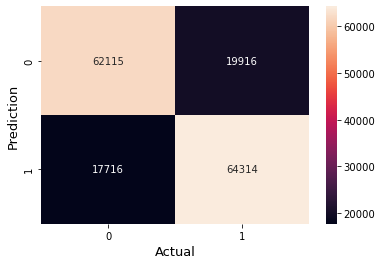

In [22]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

#Plot the confusion matrix.
sns.heatmap(cm,annot=True,fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.show()